In [7]:
import cv2
import matplotlib.pyplot as plt
from glob import glob
import shutil
import os

In [16]:
label_paths = glob('/mnt/data/rz/data/idCard/exp/20211228/train/labelTxt/*.txt')
img_root = '/mnt/data/rz/data/idCard/exp/20211228/val/images'
class_name = []
for labelp in label_paths:
	labeln = os.path.basename(labelp)
	with open(labelp) as f:
		lines = f.read().strip().split('\n')[2:]
		cls = [line.split()[8] for line in lines]
		if '94' in cls:
			print(labelp)
		class_name.extend(cls)
	# imgn = labeln.split('.')[0] + '.jpg'
	# imgp = os.path.join(img_root, imgn)
	# if not os.path.exists(imgp):
	# 	print(labelp)
	# 	os.remove(labelp)




/mnt/data/rz/data/idCard/exp/20211228/train/labelTxt/1ae1b853-ae69-4438-920d-4ce5e100690f.txt


In [14]:
from glob import glob
import os



label_paths = glob('/mnt/data/rz/data/idCard/exp/20220104/train/labelTxt/*.txt')
img_root = '/mnt/data/rz/data/idCard/exp/20220104/train/images/'
class_name = []

#检查txt文件与img文件是否一一对应
def check_label_img_file(label_paths, img_root):
	for labelp in label_paths:
		name = os.path.basename(labelp)
		imgn = name.split('.')[0] + '.jpg'
		imgp = os.path.join(img_root, imgn)
		if not os.path.exists(imgp):
			print(imgp)
			# os.remove(labelp)

# 检查标注文件的类别是否在类范围内
def check_label_file(label_paths, classes):
	for labelp in label_paths:
		with open(labelp) as f:
			content = f.read().strip().split('\n')[2:]
		for line in content:
			line = line.split()
			loc, cls, _ = line[:8], line[8], line[-1]
			if cls not in classes:
				print(labelp, '   ', line)
				break


classes = ('name', 'sex', 'birthday', 'address', 'number', 'authority', 'validity', 'nation')
check_label_file(label_paths, classes)



/mnt/data/rz/data/idCard/exp/20220104/train/labelTxt/01e4e182-363a-4758-9bf1-1caffea4f948.txt     ['273', '368', '530', '364', '526', '392', '272', '395', '272', '395', 'address', '0']


In [1]:
# 将身份证正反面分开
from glob import glob
import os
import shutil
from tqdm import tqdm

root = '/mnt/data/rz/data/idCard/v4/cornered'
img_root = os.path.join(root, 'images')
txt_root = os.path.join(root, 'labelTxt')
store_national_root = os.path.join(root, 'national')
store_person_root = os.path.join(root, 'person')

txt_paths = glob(os.path.join(txt_root, '*.txt'))

for txtp in tqdm(txt_paths):
	imgn = os.path.basename(txtp).replace('txt', 'jpg')
	imgp = os.path.join(img_root, imgn)

	with open(txtp) as f:
		content = f.read().strip().split('\n')
	classes = [line.strip().split(',')[-1] for line in content]
	# 人头面
	if 'name' in classes or 'number' in classes or 'address' in classes:
		shutil.copy(txtp, store_person_root)
		shutil.copy(imgp, store_person_root)
	else:
	# 国徽面
		shutil.copy(txtp, store_national_root)
		shutil.copy(imgp, store_national_root)


100%|██████████| 4262/4262 [00:02<00:00, 1722.26it/s]


In [3]:
# 对文件进行切分，将图片与txt进行切分
def split_dir(root, store_root, num):
	paths = glob(os.path.join(root, '*.jpg'))
	total_num = len(paths)
	package = 0
	for begin in range(0, total_num, num):
		store_package = os.path.join(store_root, str(package))
		if not os.path.exists(store_package):
			os.makedirs(store_package)
		end = begin+num if begin+num < total_num else total_num
		for p in paths[begin:end]:
			txtp = p.replace('jpg', 'txt')
			shutil.copy(p, store_package)
			shutil.copy(txtp, store_package)
		package += 1


if __name__ == '__main__':
	img_root = '/mnt/data/rz/data/idCard/v4/cornered/national/org'
	store_root = '/mnt/data/rz/data/idCard/v4/cornered/national/split'
	if not os.path.exists(store_root):
		os.makedirs(store_root)
	num = 500
	split_dir(img_root, store_root, num)


In [52]:
import json
from glob import glob
import os.path as osp
import os
import re
from tqdm import tqdm
from pprint import pprint
import shutil
import matplotlib.pyplot as plt


# 与百度预测结果做对比
pre_file_root = '/mnt/data/rz/programe/idCard/main/data/txt'
baidu_file_root = '/mnt/data/rz/data/idCard/v4/baiduLabel'
img_root= '/mnt/data/rz/data/idCard/v4/images'
error_img_store_root = '/mnt/data/rz/data/idCard/v4/predict_diff'
# pre_files = glob(osp.join(pre_file_root, '*.json'))
pre_files = glob(osp.join(error_img_store_root, '*.json'))

def baidu_parse(path):
	valid = ''
	validx = 0
	result = dict()
	with open(path) as f:
		for line in f.readlines():
			line = line.strip().split(',')
			loc = line[:8]
			loc = list(map(int, loc))
			ct = line[8]
			cls = line[9]
			x = loc[0]
			if cls == 'validity':
				if valid == '':
					valid += ct
					validx = x
				elif x < validx:
					valid = ct + '-' + valid
				else:
					valid = valid + '-' + ct
			else:
				result[cls] = ct
		if valid != '':
			result['validity'] = valid
	return result

def pre_parse(path):
	result = dict()
	valid = ''
	validx = 0
	with open(path) as f:
		content = json.loads(f.read())
		res_data = content['responseData']
		for item in res_data:
			cls = item['class_name']
			ct = item['content']
			if cls == 'validity':
				loc = item.get('location', '')
				if loc != '':
					x = loc[0]
					if valid == '':
						valid += ct
						validx = x
					elif x < validx:
						valid = ct + '-' + valid
					else:
						valid = valid + '-' + ct
			else:
				result[cls] = ct
	if valid != '':
		result['validity'] = valid
	return result


def find_unchinese(file, char):
	pattern = re.compile(r'[\u4e00-\u9fa5]')
	unchinese = re.sub(pattern,char,file)
	return unchinese


class_names = ('name', 'sex', 'birthday', 'address', 'number', 'authority', 'validity', 'nation')
metric = {cls: 0 for cls in class_names}
national_face = 0
person_face = 0
right_pic = 0
total = 0
for jpath in pre_files:
	suffix = osp.basename(jpath).replace('.json', '')
	bname = suffix + '.txt'
	baidup = osp.join(baidu_file_root, bname)

	bresult = baidu_parse(baidup)
	presult = pre_parse(jpath)

	length = len(bresult)
	if length == 0:
		continue
	for k, v in bresult.items():
		pvalue = presult.get(k, '')
		if k == 'birthday':
			person_face += 1
			pvalue = find_unchinese(pvalue, '-') # 过滤中文
			pvalue = pvalue.split('-')
			if len(pvalue) >= 3:
				y = pvalue[0]
				m = pvalue[1]
				d = pvalue[2]
				if len(m) == 1:
					m = '0' + m
				if len(d) == 1:
					d = '0' + d
				pvalue = y + m + d
		if k == 'number':
			pvalue = pvalue.replace('x', 'X')
		if k == 'authority':
			national_face += 1
		if v == pvalue:
			metric[k] += 1
			length -= 1
		else:
			# print('bresult:', v)
			# print('presult:', pvalue)
			imgn = suffix + '.jpg'
			imgp = osp.join(img_root, imgn)
			shutil.copy(imgp, error_img_store_root)
			shutil.copy(jpath, error_img_store_root)

	if length == 0:
		right_pic += 1
	total += 1


In [1]:
import json
from glob import glob
import os.path as osp
import os
import re
from tqdm import tqdm
from pprint import pprint
import shutil
import matplotlib.pyplot as plt
import cv2


# 与百度预测结果做对比
pre_file_root = '/mnt/data/rz/programe/idCard/main/data/txt'
baidu_file_root = '/mnt/data/rz/data/idCard/v4/baiduLabel'
img_root= '/mnt/data/rz/data/idCard/v4/images'
error_img_store_root = '/mnt/data/rz/data/idCard/v4/predict_diff'
# pre_files = glob(osp.join(pre_file_root, '*.json'))
pre_files = glob(osp.join(error_img_store_root, '*.json'))

def baidu_parse(path):
	valid = ''
	validx = 0
	result = dict()
	with open(path) as f:
		for line in f.readlines():
			line = line.strip().split(',')
			loc = line[:8]
			loc = list(map(int, loc))
			ct = line[8]
			cls = line[9]
			x = loc[0]
			if cls == 'validity':
				if valid == '':
					valid += ct
					validx = x
				elif x < validx:
					valid = ct + '-' + valid
				else:
					valid = valid + '-' + ct
			else:
				result[cls] = ct
		if valid != '':
			result['validity'] = valid
	return result

def pre_parse(path):
	result = dict()
	valid = ''
	validx = 0
	with open(path) as f:
		content = json.loads(f.read())
		res_data = content['responseData']
		for item in res_data:
			cls = item['class_name']
			ct = item['content']
			if cls == 'validity':
				loc = item.get('location', '')
				if loc != '':
					x = loc[0]
					if valid == '':
						valid += ct
						validx = x
					elif x < validx:
						valid = ct + '-' + valid
					else:
						valid = valid + '-' + ct
				else:
					valid = ct
			else:
				result[cls] = ct
	if valid != '':
		result['validity'] = valid
	return result


def find_unchinese(file, char):
	pattern = re.compile(r'[\u4e00-\u9fa5]')
	unchinese = re.sub(pattern,char,file)
	return unchinese

pre_file_gen = (pfile for pfile in pre_files)

In [1]:
import numpy as np

In [2]:
a = np.array([1, 2])
type(a) is np.ndarray

True

## 人头面
- 地址:
	- 地址栏有中文识别错误
	- 因为拍照环境影响，导致部分字看不清
	- 使用通用OCR的时候，地址栏字段正则匹配多次，导致有重复字段出现
	- 使用通用OCR的时候，地址栏字段上下顺序错乱
	- 生僻字直接未被识别，直接被忽略
- 号码:
	- 末尾字符X，识别成符号:×
	- 检测框右侧稍微有点偏左，也可能是四舍五入引起的
	- 检测置信度低，导致被过滤(0.8374)
- 名字:
	- 中文形近字识别错误
	- 一识别成符号—
	- 识别的置信度低（0.7568)
- 名族:
	- 少数民族识别错误
	- 检测置信度低了,导致被过滤(0.84)
- 性别:
	- 置信度比较低导致过滤掉了
- 生日:
	- 非汉文引起的识别错误，例如出现汉文与回文一起出现

## 国徽面
### 存在四个角点没有检测到，而无法矫正的情况
- 有效日期:
	- 当矫正不成功时，使用通用识别，结果不稳定,时常丢失有效日期
	- 有效日期的月份、日期字段不相等，可能右侧的字段缺少字符
	- 模糊引起的识别错误
	- 出现一些非数字字符，eg:':', ','
- 发证机关:
	- 中文形近字识别错误
	- 检测置信度低，导致被过滤

baidu:  name   覃其联
predi:  name   None
baidu:  nation   汉
predi:  nation   None
baidu:  address   广西来发市英实区玉山秀关罗村民委良村157号
predi:  address   None
baidu:  number   451302199104071810
predi:  number   None
baidu:  birthday   19910407
predi:  birthday   None
baidu:  sex   男
predi:  sex   None
file path: /mnt/data/rz/data/idCard/v4/images/5bcee50d-47d9-4f53-8248-cf5edf080bda.jpg


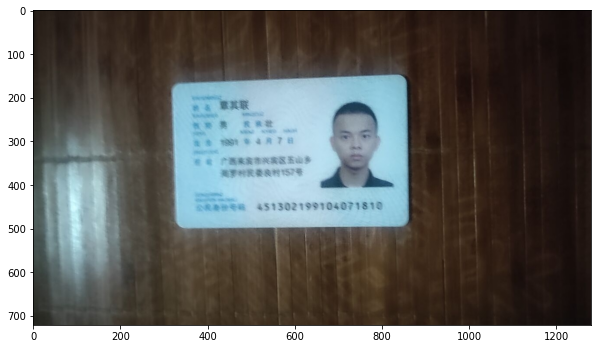

In [13]:
jpath = next(pre_file_gen)
suffix = osp.basename(jpath).replace('.json', '')
bname = suffix + '.txt'
baidup = osp.join(baidu_file_root, bname)

bresult = baidu_parse(baidup)
presult = pre_parse(jpath)
for k, v in bresult.items():
	print('baidu: ', k, ' ', v)
	print('predi: ', k, ' ', presult.get(k, None))

imgp = osp.join(img_root, suffix + '.jpg')
img = cv2.imread(imgp)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('file path:', imgp)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()


In [47]:
pprint(metric)
print('person face:', person_face)
print('national face:', national_face)
print('=========================')

acc = dict()
for k, v in metric.items():
	if k == 'authority' or k == 'validity':
		acc[k] = v / national_face
	else:
		acc[k] = v / person_face

pprint(acc)
print('total picture right:', right_pic / total)

{'address': 1756,
 'authority': 2052,
 'birthday': 2149,
 'name': 2057,
 'nation': 2162,
 'number': 2095,
 'sex': 2173,
 'validity': 2044}
person face: 2217
national face: 2251
{'address': 0.7920613441587732,
 'authority': 0.9115948467347845,
 'birthday': 0.9693279206134416,
 'name': 0.927830401443392,
 'nation': 0.975191700496166,
 'number': 0.9449706811005864,
 'sex': 0.9801533603969328,
 'validity': 0.9080408707241227}
total picture right: 0.7661145926589078


In [3]:
import json

with open('/mnt/data/rz/programe/idCard/main/data/repitle_address_extract.json') as f:
    address = json.loads(f.read())
    shang = address['上海市']

In [1]:
from fuzzywuzzy import process


lv_address = ['梅县区', '蕉岭县', '兴宁市', '丰顺县', '大埔县', '梅江区', '五华县', '平远县']
process.extractOne('梅江区长沙镇', lv_address)

('梅江区', 90)